In [1]:
import sys
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
import networkx as nx
import util_snam as us
from matplotlib import rc
import pickle
rc('font',**{'family':'serif','serif':['Roman']})
rc('text', usetex=True)

# Figure 1

We consider that the zealot nodes are part of the graphd and thus included in $N$. So there are $N-z$ free users.

In [142]:
N = 100
nz0,nz1 = 25,18 # nb of zealot nodes
z = nz0+nz1 # total nb of zealot nodes
free = N-z

Create graph

In [241]:
gtype = 'BA'
if gtype=='BA':
    ba = 8 # BA graph
    G = nx.barabasi_albert_graph(N,ba)
    W = nx.to_numpy_array(G)
elif gtype=='ER':
    er = .18 # ER graph
    W = np.random.choice((0,1),size=(N,N),p=(1-er,er))
W = W*np.random.exponential(1,(N,N))
W[N-z:,:] = 0
np.fill_diagonal(W,0)

In [242]:
weighted = True
path = f'{gtype}_weighted{weighted}_'
path

'rho_result/BA_weightedTrue_'

In [220]:
G.number_of_edges()/(N*(N-1))

0.07434343434343435

Get L, z0, z1.

In [221]:
L = np.diag(W[:N-z,:N-z].sum(axis=1))-W[:N-z,:N-z]
#z0, z1 = np.full(N-z,nz0), np.full(N-z,nz1)
z0 = W[:N-z,N-z:N-nz1].sum(axis=1)
z1 = W[:N-z,N-nz1:N].sum(axis=1)
#z0, z1 = np.random.randint(0,3,size=N-z), np.random.randint(0,3,size=N-z)
A = (W>0).astype(int) # unweighted adjacency matrix

Graph density?

In [222]:
A.sum()/(N*(N-1))

0.10777777777777778

Get equilibrium opinions xstar.

In [223]:
xstar = np.linalg.inv(L+np.diag(z0)+np.diag(z1)).dot(z1)

Get rho theory.

In [224]:
rho_mean = us.get_rho(N,W,nz0,nz1,z0,z1,xstar,weighted)

Simulate.

In [228]:
#n_steps = 300000
max_time = 50000 #n_steps/free
burn = max_time/5
save_every = N
print_every = 10000
timeit = True
rho_simu,times = us.get_rho_simu(N,nz0,nz1,W,max_time,weighted,burn,save_every,print_every,timeit)

In [243]:
dump = False
load = True
if dump:
    pickle.dump(rho_simu, open(path+f'rhoEmp.p','wb'))
    pickle.dump(times, open(path+f'times.p','wb'))
    pickle.dump(rho_mean, open(path+f'rhoTheo.p','wb'))
if load:
    rho_simu = pickle.load(open(path+'rhoEmp.p','rb'))
    times = pickle.load(open(path+'times.p','rb'))
    rho_mean = pickle.load(open(path+'rhoTheo.p','rb'))

In [237]:
len(rho_simu), np.mean(rho_simu), rho_mean

(22772, 0.45136382761258387, 0.4511985674991319)

In [238]:
error_abs = np.abs(np.mean(rho_simu)-rho_mean)
error_rel =  100*np.abs(np.mean(rho_simu)-rho_mean)/rho_mean
print(error_abs, error_rel)

0.00016526011345197045 0.03662691447979573


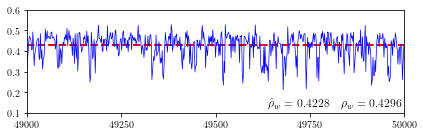

In [244]:
mini,maxi = max_time-1000,max_time
xaxis,yaxis = list(),list()
for i,t in enumerate(times):
    if t>mini and t<maxi:
        xaxis.append(t)
        yaxis.append(rho_simu[i])
fig, ax = plt.subplots(figsize=(6,2))
plt.axhline(rho_mean, lw=2, ls='--',  color='red', label=r'$\rho_w={:.4f}$'.format(rho_mean))
plt.plot(xaxis, yaxis, lw=.7, color='blue', label=r'$\rho_w={:.4f}$'.format(np.mean(rho_simu)))
plt.xlim(xaxis[0],xaxis[-1])
plt.ylim(0.1,0.6)
if gtype=='ER':
    plt.xticks([])
else:
    plt.xticks(range(mini,maxi+1,250))
if weighted:
    s = r'$\hat\rho_w={0:.4f}\quad \rho_w={1:.4f}$'.format(np.mean(rho_simu),rho_mean)
else:
    s = r'$\hat\rho={0:.4f}\quad \rho={1:.4f}$'.format(np.mean(rho_simu),rho_mean)
#plt.title()
plt.text(maxi-360,.13,s,fontsize=12)
plt.tight_layout()
plt.savefig(path+f"plot.eps")
plt.show()
plt.close()

# Figure 2 (data)

Initialise.

In [2]:
df = pd.read_csv('HSall_parties.csv')
df = df[df.chamber=='House']
df.drop(['chamber','party_code','nominate_dim1_median','nominate_dim2_median','nominate_dim1_mean','nominate_dim2_mean']
        ,axis=1,inplace=True)
df.head()

,congress,party_name,n_members
1,1,Anti-Administration,29
2,1,Pro-Administration,37
6,2,Anti-Administration,32
7,2,Pro-Administration,40
11,3,Anti-Administration,56


Look at proportion of Democrats and Republicans over time.

In [3]:
congress = np.unique(df.congress.values)
prop_dem, prop_rep, total =list(), list(), list()
for c in congress:
    df_ = df[df.congress==c]
    N = df_.n_members.sum()
    if 'Democrat' in df_.party_name.values:
        prop_dem.append(df_[df_.party_name=='Democrat'].n_members.values[0] /N)
    else:
        prop_dem.append(0)
    if 'Republican' in df_.party_name.values:
        prop_rep.append(df_[df_.party_name=='Republican'].n_members.values[0] /N)
    else:
        prop_rep.append(0)
    total.append(N)
prop_demrep = np.array(prop_dem)+np.array(prop_rep)  

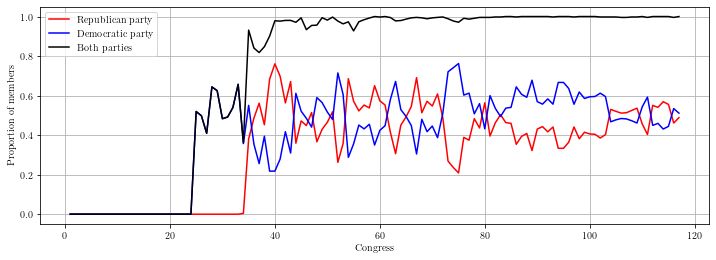

In [4]:
fig,ax = plt.subplots(figsize=(12,4))
plt.plot(congress,prop_rep,c='red',label='Republican party')
plt.plot(congress,prop_dem,c='blue',label='Democratic party')
plt.plot(congress,prop_demrep,c='black',label='Both parties')
plt.grid()
plt.xlabel('Congress')
plt.ylabel('Proportion of members')
plt.legend(loc='best')

In [5]:
min(prop_demrep[80:])

0.9954545454545454

From 80 congress onwards, there is always >99.5% Republicans+Democrats in the House, making our analysis very relevant. So that's where we start.

In [6]:
congress_min, congress_max = 80, 118
df = df[df.congress>=congress_min]
df = df[df.congress<congress_max]
df.reset_index(drop=True,inplace=True)

In [7]:
df.head()

,congress,party_name,n_members
0,80,Democrat,194
1,80,Republican,253
2,80,American Labor,2
3,81,Democrat,267
4,81,Republican,176


We transform the dataset to have one row per congress. We ignore indepentds (there are very few of them and our model doest not account for more than 2 parties for now).

In [8]:
dem = df[df.party_name=='Democrat']['n_members'].values
rep = df[df.party_name=='Republican']['n_members'].values

In [9]:
dico = {'congress':range(congress_min,congress_max),'dem':dem,'rep':rep,'total':dem+rep}
df = pd.DataFrame.from_dict(dico)

In [10]:
df.head()

,congress,dem,rep,total
0,80,194,253,447
1,81,267,176,443
2,82,240,207,447
3,83,218,222,440
4,84,235,203,438


In [11]:
N = df.total.max() # we set the number of seats to its maximum

In [12]:
df.total.min(), df.total.max()

(438, 453)

Compute average empirical diversity (sigma) over time.

In [13]:
sigma_emp = us.get_sigma_complete(df.dem,df.rep).mean()
sigma_emp

0.970801230417951

Now compute theoretical sigma as well as theoretical and empirical rho for all possible pairs (z0,z1). We also compute errors between theory and empirical.

In [14]:
n_row = df.shape[0]
error_abs = {'sigma':dict(), 'rho':dict(), 'full':dict()}
error_rel = {'sigma':dict(), 'rho':dict(), 'full':dict()}
min_dem, min_rep = df.dem.min(), df.rep.min() # those are maximum values for z0,z1 across all data

for z0 in range(1,min_dem+1):
    for z1 in range(1,min_rep+1):
        sigma_theo, rho_emp, rho_theo = 0,0,0
        for c,dem,rep,total in df.values:
            sigma_theo += us.get_sigma_complete(z0,z1)
            rho_emp += (2*dem*rep -dem*z1 -rep*z0) /(total*(total-1))
            rho_theo += us.get_rho_complete(total,z0,z1)
        sigma_theo, rho_emp, rho_theo = sigma_theo/n_row, rho_emp/n_row, rho_theo/n_row
        error_abs['sigma'][z0,z1] = abs(sigma_theo-sigma_emp)#*100/sigma_emp
        error_abs['rho'][z0,z1] = abs(rho_theo-rho_emp)#*100/rho_emp
        error_abs['full'][z0,z1] = (error_abs['sigma'][z0,z1]+error_abs['rho'][z0,z1])/2
        error_rel['sigma'][z0,z1] = abs(sigma_theo-sigma_emp)*100/sigma_emp
        error_rel['rho'][z0,z1] = abs(rho_theo-rho_emp)*100/rho_emp
        error_rel['full'][z0,z1] = (error_rel['sigma'][z0,z1]+error_rel['rho'][z0,z1])/2

Now find the argmin of the error.

In [15]:
metric = ('sigma','rho')
z0_data, z1_data = min_dem, min_rep
error_abs_final = 1
error_rel_final = 1

for z0 in range(1,min_dem+1):
    for z1 in range(1,min_rep+1):
        err = error_abs['full'][z0,z1]
        if err < error_abs_final:
            z0_data, z1_data, error_abs_final = z0, z1, err
        elif err == error_abs_final:
            if z0+z1 < z0_data + z1_data:
                z0_data, z1_data, error_abs_final = z0, z1, err
error_rel_final = error_rel['full'][z0_data,z1_data]

In [16]:
metric_data = {'sigma':us.get_sigma_complete(z0_data,z1_data),
                      'rho': us.get_rho_complete(N,z0_data,z1_data)}

In [17]:
print(min_dem, min_rep, z0_data, z1_data, error_abs_final, error_rel_final, metric_data, sep='\n\n')

190

143

89

63

3.792540933120203e-05

0.005560817266483827

{'sigma': 0.9707409972299169, 'rho': 0.3211098249267103}


## Optimising with $z_0,z_1$

In [18]:
alpha_range = np.linspace(0,.99,100)
yaxis = dict()
for m in metric:
    for z in (0,1):
        yaxis[m,z] = {'z':list(), 'sigma':list(), 'rho':list()}

for a in alpha_range:
    z0,sigma = us.max_sigma_complete(N,z1_data,a)
    rho = us.get_rho_complete(N,z0,z1_data,a)
    yaxis['sigma',0]['z'].append(z0)
    yaxis['sigma',0]['sigma'].append(sigma)
    yaxis['sigma',0]['rho'].append(rho)
    
    z1,sigma = us.max_sigma_complete(N,z0_data,a)
    rho = us.get_rho_complete(N,z0_data,z1,a)
    yaxis['sigma',1]['z'].append(z1)
    yaxis['sigma',1]['sigma'].append(sigma)
    yaxis['sigma',1]['rho'].append(rho)
    
    z0,rho = us.max_rho_complete(N,z1_data,a)
    sigma = us.get_sigma_complete(z0,z1_data,a)
    yaxis['rho',0]['z'].append(z0)
    yaxis['rho',0]['sigma'].append(sigma)
    yaxis['rho',0]['rho'].append(rho)
    
    z1,rho = us.max_rho_complete(N,z0_data,a)
    sigma = us.get_sigma_complete(z0_data,z1,a)
    yaxis['rho',1]['z'].append(z1)
    yaxis['rho',1]['sigma'].append(sigma)
    yaxis['rho',1]['rho'].append(rho)

Axes limits.

In [19]:
ymin = {'sigma':.5,'rho':0}
ymax = {'sigma':1,'rho':0.5}

Plot.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


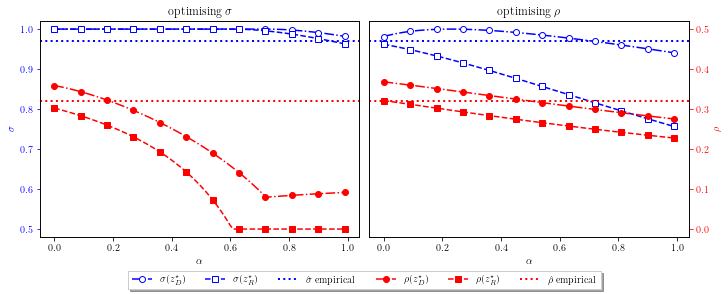

In [20]:
party = {0:'D',1:'R'}
label = {m: r'$\{}$'.format(m) for m in metric}
label_optim = {(m,z): r'$\{}(z_{}^\star)$'.format(m,party[z]) for m in metric for z in (0,1)}
label_hline = {m: r'$\hat\{}$ empirical'.format(m) for m in metric}
title = {(m): r'optimising $\{}$'.format(m) for m in metric}
color = {'sigma':'blue','rho':'red'}
marker = {0:'o', 1:'s'}
every = 9
loc = {'sigma':'left','rho':'right'} # for spines
ls = {0:'-.', 1:'--'}
facecolor = {'sigma':'white', 'rho':None}
handles, labels = list(), list()
plot, hline = dict(), dict()

fig,ax = plt.subplots(1,2,figsize=(10,4))

for i,m in enumerate(metric):
    ax[i].set_xlabel(r'$\alpha$')
    ax[i].set_title(title[m])
    ax_ = {'sigma':ax[i], 'rho':ax[i].twinx()}
    if m=='sigma':
        ax_['rho'].get_yaxis().set_visible(False)
    else:
        ax_['sigma'].get_yaxis().set_visible(False)
    for m2 in metric:
        hline[m2] = ax_[m2].axhline(metric_data[m2],ls=':',lw=2,c=color[m2])
        ax_[m2].set_ylim(ymin[m2]-.02,ymax[m2]+.02)
        for z in (0,1):
            plot[m2,z], = ax_[m2].plot(alpha_range, yaxis[m,z][m2], c=color[m2], marker=marker[z], markevery=every, 
                         ls=ls[z], markerfacecolor=facecolor[m2])
    ax_[m].tick_params(axis='y', colors=color[m])
    ax_[m].set_ylabel(label[m], color=color[m])

for m in metric:
    for z in (0,1):
        handles.append(plot[m,z])
        labels.append(label_optim[m,z])
    handles.append(hline[m])
    labels.append(label_hline[m])
fig.legend(handles, labels, loc='lower center', ncol=6, fancybox=False, shadow=True)#, columnspacing=1.5)
fig.tight_layout(rect=[0, .08, 1, 1], pad=.3)  

plt.savefig(f'data_optim.eps')
plt.show()
plt.close()

Now plot z...

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


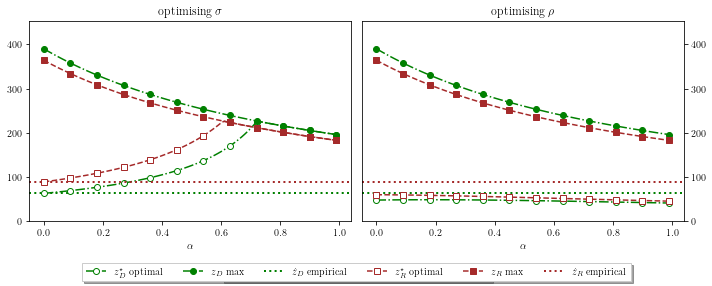

In [21]:
label = {m: r'$\{}$'.format(m) for m in metric}
label_optim = {z: r'$z_{}^\star$ optimal'.format(party[z]) for z in (0,1)}
label_max = {z: r'$z_{}$ max'.format(party[z]) for z in (0,1)}
label_hline = {z: r'$\hat z_{}$ empirical'.format(party[z]) for z in (0,1)}
title = {m: r'optimising $\{}$'.format(m) for m in metric}
color = {0:'green',1:'brown'}
marker = {0:'o', 1:'s'}
every = 9
ls = {0:'-.', 1:'--'}
facecolor = {0:'white', 1:None}
handles, labels = list(), list()
plot, plot2, hline = dict(), dict(), dict()
#ymin,ymax = 0,N

fig,ax = plt.subplots(1,2,figsize=(10,4))

zmax = dict()
zmax[0] = [(N-z1_data)/(1+a) for a in alpha_range]
zmax[1] = [(N-z0_data)/(1+a) for a in alpha_range]

for i,m in enumerate(metric):
    ax[i].set_xlabel(r'$\alpha$')
    ax[i].set_title(title[m])
    ax[i].set_ylim(0,N)
    if m=='rho':
        ax[i].yaxis.tick_right()
    for z in (0,1):
        #yax = [y/zmax[z][j] for j,y in enumerate(yaxis[m,z]['z'])]
        if z==0:
            hline[z] = ax[i].axhline(z1_data,ls=':',lw=2,c=color[z])
        else:
            hline[z] = ax[i].axhline(z0_data,ls=':',lw=2,c=color[z])
        plot[z], = ax[i].plot(alpha_range, yaxis[m,z]['z'], c=color[z], markerfacecolor='white',
                                marker=marker[z], markevery=every, ls=ls[z])
        plot2[z], = ax[i].plot(alpha_range, zmax[z], c=color[z], markerfacecolor=None,
                                marker=marker[z], markevery=every, ls=ls[z])
        #ax[i].set_ylim(ymin[m2]-.02,ymax[m2]+.02)

for z in (0,1):
    handles.append(plot[z])
    labels.append(label_optim[z])
    handles.append(plot2[z])
    labels.append(label_max[z])
    handles.append(hline[z])
    labels.append(label_hline[z])
    fig.legend(handles, labels, loc='lower center', ncol=6, fancybox=False, shadow=True)
    fig.tight_layout(rect=[0, .08, 1, 1])  


plt.savefig(f'data_argoptim.eps')
plt.show()
plt.close()